In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
import logging
sys.path.append("/usr/wrk/people9/sima9999/code/")
sys.path.append("/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/")
import matplotlib
# a bug in jupyter / ipympl / matplotlib needs this here when using %maptlotlib widget
# somehow rc_context is broken in that case
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
# to adjust figure uncomment here and comment out %matplotlib widget, restart kernel and 
# make sure jupyterlab is running in a x-forwarded and connected ssh session and the right display is set
# os.environ['DISPLAY'] = 'localhost:17.0'
# matplotlib.use("qtagg")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.stats.qmc

import ray

from uncertainty.polymorphic_uncertainty import *
from uncertainty.data_manager import DataManager
from helpers import get_pcd

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc -ray

### Verification example: numerical modal analysis ###

System: Vibrating beam, hinged and flexibly supported
Input parameters and uncertainties:
- Cross-sectional area properties: polymorphic - e.g. due to manufacturing tolerances 
    - ellipse radius $a=0.9$: deterministic (to reduce dimension of design space)
    - ellipse radius $b$: imprecision
        - [0.85 ... 0.95] m deformed state; m=1
    - Wall thickness $t$: mixed - imprecision & variability
        - [5.9,6.1e-3] nominal; m=0.8
        - Normal(6e-3, 1e-4); m= 0.2

- Additional mass (plattforms, cables, antennas, etc.): imprecision
    - [0.2-1 kN/m Petersen: Stahlbau]

- Pre-tension of Guy wires: incompleteness -  due to unknown nominal state and variable temperature effects
    - Nominal state $\mu_N$ : mixed - deterministic & imprecision
        - 60000 N design value; m=0.75
        - [40000 - 180000] N; m=0.25
    - Normal($\mu_N$,2655) N; 
        -Standard deviation obtained from Geyer Monitoring Temperature Data with $N_\text{wire} = N_\text{nominal} - \alpha_t \Delta_t E A \cos^2(\alpha)$

- Cross-Sectional Area of wires: imprecision - due to manufacturing tolerances
    - [0.0007,0.0008] m; m=1

- Damping ratio: imprecision
    - [Petersen, 2017, P143] for low, medium, high vibration amplitudes: 
        - $\Lambda$=[0.008, 0.013, 0.018] (steel) + [0.035,0.04,0.06] (guyed masts) + [0.004,0.005,0.006] (concrete foundation)
        - $\zeta = \frac{\Lambda}{\sqrt{(2\pi)^2+\Lambda^2}} \approx \frac{\Lambda}{2\pi}$
    - VDI2038-2, Table 1, p. 14: $\zeta$=[0.0016, 0.015]
    - damping ratio [each m=0.3]: [0.0075, 0.0092],[0.0075, 0.0134], [0.0016, 0.015] 

- Viscosity of the TMD damper: incompleteness - due to unknown temperature-viscosity relations
    - Standard Deviation $\sigma_D$:
    - mean temp = 8.62, stdd temp = 8.19 (Geyer north sensor)
    - $F = \eta A   \frac{v}{h}$ ($\eta$: Viscosity, $A$ shear area, $v$ fluid velocity, $h$ height of the fluidlayer)
    - Daempfungskonstante: $\frac{F}{v} = \eta \frac{A}{h}$ [N s m^-2  m^2 m^-1 = N s m^-1]
    - $\eta = -6.23e-3 T + 8.45e-1$
    - $dD(T) = -1.557 T + 2.11e2$
    - $\sigma_{dD} = 12.75$
        - (10,15) N s m^-1; m=0.8
        - (5,20) N s m^-1; m=0.2
    - Normal(197.61, $\sigma_{dD}$)  N s m^-1
    
- Icing: incompletenes & variability & imprecision
     - probability of occurence: mixed - deterministic & imprecision 
         - [[28.2/365 = 0.077], [1/365, 77/365]] https://www.dwd.de/DE/wetter/wetterundklima_vorort/thueringen/erfurt/_node.html
    - occurence: variability
        - Bernoulli distribution
    - mass: imprecision
        - (EN DIN EN 1991-1-3/NA:2019-04: [0.5 - 1] kN/m )

- Young's Modulus $E$: deterministic 2.1e11 N/m^2
- mass density $\rho$: deterministic 7850 kg/m^3
- TMD mass $m$: deterministic 800 kg
- TMD stiffness $k_{y,z}$: deterministic 1025.48 N/m
- Degrees-of-freedom $n$: deterministic - 200
- number of modes considered $n_m$: deterministic - 14
- Sampling rate $f_s$: deterministic - 10 Hz
- Frequency lines $N$: deterministic - 1025
- Measurement locations $x_m$: deterministic - 5


    
Output parameters:
- damped modal frequencies: $f_{d,1} \ldots f_{d,14}$
- modal damping: $\zeta_1 \ldots \zeta_{14}$
- FRF (Magnitude) at length $x$ (also includes modeshapes) due to tip excitation: $\mathcal{H}_\mathrm{a}(\omega_\mathrm{f})$

In [2]:
from UQ_Modal_Beam import mapping_function, vars_definition, est_imp, opt_inc

##### Uncertainty Modeling

In [3]:
vars_ale, vars_epi, arg_vars = vars_definition()
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 13717 # N_mcs = 1e6 = N_mcs_ale * N_mcs_epi
N_mcs_epi = 729 # = 3^6 = 2.56^n_imp ~ 3^n_imp -> cover every corner and midpoints in a full-factorial design (but distributed)
use_dm = True
result_dir = '/usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/'

### Sampling

In [4]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    # seed 1165763483 scrambles adequately to achieve good discrepancy values even for few (100) samples
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=1165763483)
    poly_uq.save_state(os.path.join(result_dir,'polyuq_samp.npz'))
else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'))

if False:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, kind='hist')
dm_grid = None

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz


### Propagation

In [ ]:
'''
blimits -l Batch72 
CPULIMIT                
4320.0 min of makalu101 -> 9 hrs @ 8 tasks -> 24 hrs @ 3 tasks -> 72 hrs @ 1 task
RUNLIMIT                
4800.0 min
TASKLIMIT               
512

FILELIMIT STACKLIMIT CORELIMIT MEMLIMIT PROCESSLIMIT
125500000 K  512000 K  100000 K  380000000 K    1000      
 
blimits -l Batch24 
CPULIMIT                
1440.0 min of makalu101 -> 6 hrs @ 4 tasks -> 24 hrs @ 1 task
TASKLIMIT               
512

FILELIMIT STACKLIMIT CORELIMIT MEMLIMIT PROCESSLIMIT
100000000 K  512000 K  100000 K  80000000 K     100   
 

blimits -l BatchXL 
TASKLIMIT               
4000

CORELIMIT MEMLIMIT PROCESSLIMIT THREADLIMIT
100000 K  256000000 K   16384        32768  

'''

if dm_grid is None:
    dm_grid = DataManager.from_existing('uq_modal_beam.nc',
                                        result_dir=os.path.join(result_dir, 'samples'), 
                                        working_dir='/dev/shm/womo1998/')

# with dm_grid.get_database('out',rw=True) as out_ds:
#     out_ds['_runtimes'][:]=np.nan
    
# dm_grid.evaluate_samples(mapping_function, arg_vars, 
#                      ret_names={'damp_freqs':('modes',), 'zetas':('modes',), 'frf':('frequencies','space',)}, 
#                      default_len={'modes':14, 'frequencies':1025, 'space':2}, dry_run=False,
#                     chunks_submit=100000, chunks_save=15000, scramble_evaluation=False, re_eval_sample='1ddf809fb7f3_b5b3e888fca2')
eval_cost = 22 # seconds
num_workers = 440
sav_time= 800 # seconds
chunks_save = sav_time/eval_cost*num_workers # 16000 
todo = True
while todo:
    logger = logging.getLogger('uncertainty.data_manager')
    logger.setLevel(level=logging.INFO)
    logger = logging.getLogger('model.mechanical')
    logger.setLevel(level=logging.WARNING)
    
    todo = dm_grid.evaluate_samples(mapping_function, arg_vars, 
                         ret_names={'damp_freqs':('modes',), 'zetas':('modes',), 'frf':('frequencies','space',)}, default_len={'modes':14, 'frequencies':1025, 'space':3}, 
                         use_lock=False, dry_run=False,
                         chunks_submit=250000, chunks_save=10000, scramble_evaluation=False)

In [12]:
ray.shutdown()

### export from datamanager

In [5]:
if dm_grid is None:
    dm_grid = DataManager.from_existing('uq_modal_beam.nc',
                                        result_dir=os.path.join(result_dir, 'samples'), 
                                        working_dir='/dev/shm/womo1998/')
with dm_grid.get_database('out',False) as out_ds:
    out_ds_keep = out_ds.load().copy()
out_ds = out_ds_keep

In [7]:
def export(poly_uq, ret_name, ret_ind, out_ds, result_dir):
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    samp_path = os.path.join(result_dir,'polyuq_samp.npz')
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
    imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')

    poly_uq.load_state(samp_path, differential='samp')
    poly_uq.N_mcs_ale = 13717
    
    if os.path.exists(prop_path):
        poly_uq.load_state(prop_path, differential='prop')
    if os.path.exists(imp_path):
        poly_uq.load_state(imp_path, differential='imp')
    
    poly_uq.from_data_manager(None, ret_name, ret_ind, out_ds)
    
    if ret_name == 'damp_freqs':
        poly_uq.out_valid = [np.nanmin(poly_uq.out_samp),np.nanmax(poly_uq.out_samp)]
    poly_uq.save_state(prop_path, differential='prop')
    if os.path.exists(imp_path):
        poly_uq.save_state(imp_path, differential='imp')
        
        
if True:
    for ret_name in ['damp_freqs','zetas','frf'][2:]:
        if ret_name == 'frf':
            # continue
            inds = range(534*3,1025*3)
        else:
            continue
            inds = range(14)

        for ind in inds:
            if ret_name == 'frf':
                ret_ind = {'frequencies':ind//3, 'space':ind%3}
                if ind%3!=2:
                    continue
            else:
                ret_ind = {'modes':ind}
            try:
                export(PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex), ret_name, ret_ind, out_ds, result_dir)
            except Exception as e:
                print(e)
                yesno = input('retry? y/n')
                if yesno=='y':
                    export(PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex), ret_name, ret_ind, out_ds, result_dir)
                
                

else:
    export(PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex), ret_name, ret_ind, out_ds, result_dir)

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/frf-534.2/polyuq_prop.npz
INFO:uncertainty.polymorphic_uncertainty:Importing propagated samples from DataManager using the output variable frf
INFO:uncertainty.polymorphic_uncertainty:Saving state of PolyUQ to /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/frf-534.2/polyuq_prop.npz. Make sure to store your variable definitions script externally...
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/frf-535.2/polyuq_prop.npz
INFO:uncertainty.polymorphic_uncertainty:Imp

### define output quantity

In [5]:
logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.INFO)

ret_name = ['damp_freqs','zetas','frf'][0]
if ret_name == 'frf':
    ret_ind = {'frequencies':559, 'space':2}
else:
    ret_ind = {'modes':10}
ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
samp_path = os.path.join(result_dir,'polyuq_samp.npz')
prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')

### Estimate imprecision

In [12]:
# ret_ind = {'frequencies':533, 'space':1}
# ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)

est_imp(poly_uq, result_dir, ret_name, ret_ind)


INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/frf-559.2/polyuq_prop.npz
restarting frf-559.2 at sample 5391
INFO:uncertainty.polymorphic_uncertainty:Estimating imprecision intervals by surrogate optimization (genetic)...


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1134, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 311, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/usr/wrk/people9/sima9999/.conda/envs/py310/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2062, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/usr/wrk/people9/sima9999/.conda/envs/py310/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2098, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt

KeyboardInterrupt



In [ ]:
plt.close('all')
for ret_name in ['damp_freqs','zetas','frf']:
    
    fig1, ax1 = plt.subplots()
    if ret_name == 'frf':
        # continue
        inds = range(10*3)
    else:
        continue
        inds = range(14)
    
    all_undershots = []
    num_undershots = []
    all_exceeds = []
    num_exceeds = []
    for ind in inds:
        if ret_name == 'frf':
            ret_ind = {'frequencies':ind//3, 'space':ind%3}
            if ind%3==0:
                continue
        else:
            ret_ind = {'modes':ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        samp_path = os.path.join(result_dir,'polyuq_samp.npz')
        prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
        imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
        
        if not os.path.exists(imp_path): continue    
    
        poly_uq.load_state(samp_path, differential='samp')
        poly_uq.load_state(prop_path, differential='prop')
        poly_uq.load_state(imp_path, differential='imp')
        
        if poly_uq.imp_foc is not None:
            samp_fin = np.nonzero(
                    np.any(
                        np.isnan(poly_uq.imp_foc[:,:,0]),
                        axis=1)
                )[0]
            print(samp_fin)
            if len(samp_fin)>0:
                start_ale = np.min(samp_fin)
            else:
                start_ale = poly_uq.imp_foc.shape[0]
            print(start_ale)
        
        undershot = poly_uq.intp_undershot
        all_undershots.append(undershot[1] / undershot[0] / (poly_uq.out_valid[1]-poly_uq.out_valid[0])*100)
        all_undershots.append(0)
        num_undershots.append(undershot[0])
        num_undershots.append(poly_uq.N_mcs_ale*len(poly_uq.imp_hyc_foc_inds) - undershot[0])
        
        exceed = poly_uq.intp_exceed
        all_exceeds.append(exceed[1] / exceed[0] / (poly_uq.out_valid[1]-poly_uq.out_valid[0])*100)
        all_exceeds.append(0)
        num_exceeds.append(exceed[0])
        num_exceeds.append(poly_uq.N_mcs_ale*len(poly_uq.imp_hyc_foc_inds) - exceed[0])
        
        ax1.hist(100-poly_uq.intp_errors*100, bins=np.arange(101), alpha=0.1)
        
    ax1.set_title(f'Interpolator LOO Cross-Validation {ret_name}')
    ax1.set_xlabel("Accuracy [\%]")
    ax1.set_ylabel("Sample Count [-]")
    fig1.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/imp_loo_accuracy{ret_name}.png')
    fig1.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/imp_loo_accuracy{ret_name}.pdf')

    plt.figure()
    plt.hist(all_undershots, weights= num_undershots, bins=50)
    plt.title(ret_name + ' undershot error')

    plt.figure()
    plt.hist(all_exceeds, weights= num_exceeds, bins=50)
    plt.title(ret_name + ' exceed error') 

### Estimate Incompleteness

In [10]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
result_dir = '/usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/'
ret_name = 'frf'
for freq_ind in range(380,1025):
    for space_ind in [1,2]:
        ret_ind = {'frequencies':freq_ind, 'space':space_ind}
        opt_inc(poly_uq, result_dir, ret_name, ret_ind)

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/frf-380.1/polyuq_prop.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/frf-380.1/polyuq_imp.npz
stat_fun_avg
INFO:uncertainty.polymorphic_uncertainty:Estimating incompleteness intervals by direct L-BFGS optimization of statistics over input hypercubes...
............................................


KeyboardInterrupt



### Plots

In [ ]:
plt.close('all')
with matplotlib.rc_context(get_pcd('print')):
    ret_name = 'zetas'
    for mode_ind in range(14):
        plt.figure()
        ret_ind = {'modes':mode_ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

        arr = np.load(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz'))
        focals_stats, focals_mass = arr['self.focals_stats'], arr['self.focals_mass']

        plot_focals(focals_stats[0,:,:], focals_mass, plt.gca())
        if ret_name == 'damp_freqs':
            plt.xlabel(f'$f_{{{mode_ind+1}}}  [\si{{\hertz}}]$')
        elif ret_name == 'zetas':
            plt.xlabel(f'$\\zeta_{{{mode_ind+1}}}  [\si{{\percent}}]$')
            
        plt.ylim((0,1))
        plt.ylabel('Cumulative Mass [-]')
        plt.subplots_adjust(top=0.97, bottom=0.135, left=0.105, right=0.97, wspace=0.045)
        
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_foc-{ret_dir}.png')
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_foc-{ret_dir}.pdf')
        
        plt.show()

In [9]:
focals_mass.shape

(96,)

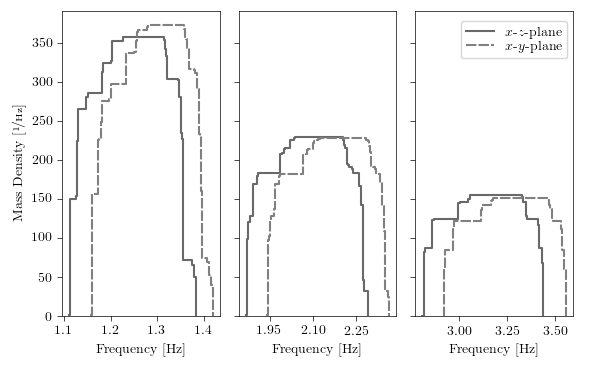

In [11]:
with matplotlib.rc_context(get_pcd('print')):
    fig, axes = plt.subplots(1,3, sharey=True)
    ret_name='damp_freqs'
    colors=['dimgrey','grey']
    linestyles = ['solid', (0, (5, 1))]
    add_mode = 4 # 0 or 4
    if not add_mode:
        axes = np.insert(axes, 0, axes[0])
    for mode_pair,ax in enumerate(axes):
        for pair_member in range(2):
            mode_ind = (mode_pair + add_mode)* 2 + pair_member
            ret_ind = {'modes':mode_ind}
            ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
            arr = np.load(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz'))
            focals_stats, focals_mass = arr['self.focals_stats'], arr['self.focals_mass']

            bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)

            dbins = np.diff(bins_bel)
            pl_stats[0,1:] /= dbins
            if not add_mode and mode_pair < 2:
                pl_stats /= 2
            # print(pl_stats.shape, bins_bel.shape)
            # bins_bel = np.insert(bins_bel, 0, bins_bel[0], axis=0)
            bins_bel = np.append(bins_bel, bins_bel[-1:], axis=0)
            # pl_stats = np.insert(pl_stats, 0, 0, axis=1)
            pl_stats = np.append(pl_stats, [[0]], axis=1)

            ax.step(bins_bel, pl_stats[0,:], where='post',label='plausibility', color=colors[pair_member], linestyle=linestyles[pair_member])
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        
    custom_lines = [matplotlib.lines.Line2D([0], [0], color=colors[i], ls=linestyles[i]) for i in range(2)]
    fig.legend(custom_lines, ['$x$-$z$-plane', '$x$-$y$-plane',], loc=(0.78,0.84))

    # if not add_mode:
    #     axes[0].set_xlabel('$f^\\text{u,l}_{1} [\si{{\hertz}}]$')
    #     axes[2].set_xlabel('$f_{2} [\si{{\hertz}}]$')
    #     axes[3].set_xlabel('$f_{3} [\si{{\hertz}}]$')
    # else:
    #     axes[0].set_xlabel('$f_{4} [\si{{\hertz}}]$')
    #     axes[1].set_xlabel('$f_{5} [\si{{\hertz}}]$')
    #     axes[2].set_xlabel('$f_{6} [\si{{\hertz}}]$')
    if not add_mode:
        axes[0].set_xlabel('Frequency $[\si{{\hertz}}]$')
        axes[2].set_xlabel('Frequency $[\si{{\hertz}}]$')
        axes[3].set_xlabel('Frequency $[\si{{\hertz}}]$')
    else:
        axes[0].set_xlabel('Frequency $[\si{{\hertz}}]$')
        axes[1].set_xlabel('Frequency $[\si{{\hertz}}]$')
        axes[2].set_xlabel('Frequency $[\si{{\hertz}}]$')


    axes[0].set_ylim(ymin=0)
    axes[0].set_ylabel('Mass Density [$\sfrac{1}{\si{\hertz}}$]')
    plt.subplots_adjust(top=0.97, bottom=0.135, left=0.105, right=0.97, wspace=0.12)
    if not add_mode:
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-damp_freqs-low.png')
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-damp_freqs-low.pdf')
    else:
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-damp_freqs-high.png')
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-damp_freqs-high.pdf')
    plt.show()
        

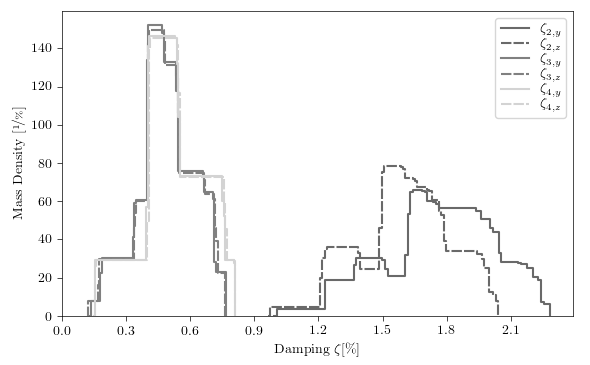

In [10]:
with matplotlib.rc_context(get_pcd('print')):
    fig, ax = plt.subplots(1,1)
    ret_name='zetas'
    add_mode = 2
    # add_mode = 0
    if not add_mode:
        colors=['dimgrey','grey']
        labels=['$\zeta^\\text{l}_{1,y}$','$\zeta^\\text{l}_{1,z}$','$\zeta^\\text{u}_{1,y}$','$\zeta^\\text{u}_{1,z}$',]
    else:
        colors=['dimgrey','grey', 'lightgrey']
        labels=['$\zeta_{2,y}$','$\zeta_{2,z}$','$\zeta_{3,y}$','$\zeta_{3,z}$','$\zeta_{4,y}$','$\zeta_{4,z}$',]

    linestyles = ['solid', (0, (5, 1))]


    for mode_pair, color in enumerate(colors):
        for pair_member in range(2):
            mode_ind = (mode_pair  + add_mode) * 2 + pair_member
            ret_ind = {'modes':mode_ind}
            ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
            arr = np.load(os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz'))
            focals_stats, focals_mass = arr['self.focals_stats'], arr['self.focals_mass']

            bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
            bins_bel *= 100
            dbins = np.diff(bins_bel)
            pl_stats[0,1:] /= dbins
            if len(colors)==2:
                pl_stats /= 2
            bins_bel = np.append(bins_bel, bins_bel[-1:], axis=0)
            pl_stats = np.append(pl_stats, [[0]], axis=1)

            ax.step(bins_bel, pl_stats[0,:], where='post', color=color, linestyle=linestyles[pair_member], label=labels[mode_pair*2+pair_member])
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    # ax.set_xlabel(f'$f_{{{mode_pair+add_mode+1},y,z}} [\si{{\hertz}}]$')

    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.set_ylabel('Mass Density [$\sfrac{1}{\si{\percent}}$]')
    ax.set_xlabel(f'Damping $\zeta [\si{{\percent}}]$')

    plt.legend(loc='upper right')
    plt.subplots_adjust(top=0.97, bottom=0.135, left=0.105, right=0.97, wspace=0.045)

    if not add_mode:
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-zetas-low.png')
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-zetas-low.pdf')
    else:
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-zetas-high.png')
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-zetas-high.pdf')
    plt.show()

In [6]:
plt.close('all')
# for mode in range(14):
    
#     ret_ind = {'modes':mode}
#     ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
#     poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
#     samp_path = os.path.join(result_dir,'polyuq_samp.npz')
#     prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
#     imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
    
#     for inc_path_part in ['polyuq_hist_inc.npz', 'polyuq_cdf_inc.npz'][1:]:

inc_path_part = 'polyuq_hist_inc.npz'
# inc_path_part = 'polyuq_cdf_inc.npz'
inc_path = os.path.join(result_dir, 'estimations', ret_dir, inc_path_part)
poly_uq.load_state(samp_path, differential='samp')
poly_uq.load_state(prop_path, differential='prop')
poly_uq.load_state(imp_path, differential='imp')
poly_uq.load_state(inc_path, differential='inc')
focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
n_stat = focals_stats.shape[0]
if False:
    fix, axes = plt.subplots(8,5,sharex=True, sharey=True)
    for i_stat in range(n_stat):
        plot_focals(focals_stats[i_stat,:,:],focals_mass, axes.flat[i_stat])

bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
n_bins_bel = bins_bel.shape[0]
with matplotlib.rc_context(get_pcd('print')):
    # fig, ax1 = plt.subplots()
    # plt.rc('text',usetex=True)
    # print(matplotlib.rcParams)
    if 'cdf' in inc_path_part:
        plt.figure()
        n_stat,n_hyc,_ = focals_stats.shape
        target_probabilities = np.linspace(0,1,n_stat)
        for i_hyc in range(n_hyc):
            for minmax in range(2):
                plt.step(focals_stats[:,i_hyc,minmax],target_probabilities,  where='post', c='grey')

        if ret_name == 'zetas':
            plt.xlabel(f'Damping $\\zeta_{ret_ind["modes"]+1} [\si{{\percent}}_\\mathrm{{crit.}}]$')
            plt.ylabel('Cumulative Probability [$-$]')
        elif ret_name == 'damp_freqs':
            plt.xlabel(f'$f_{{{{{ret_ind["modes"] + 1}}}}} [\si{{\hertz}}]$')
            plt.ylabel('Cumulative Probability [$-$]')

        plt.ylim((0,1))
        plt.xlim((np.nanmin(focals_stats), np.nanmax(focals_stats))) 
        plt.subplots_adjust(top=0.975,bottom=0.125, left=0.09,right=0.98)
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_cdf_foc-{ret_dir}.png')
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_cdf_foc-{ret_dir}.pdf')

    if True:
        plt.figure()
        if 'hist' in inc_path_part:
            nbin_fact=20
            n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
            bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(poly_uq.N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2)
            if ret_name == 'zetas':
                bins_densities *=100
            plt.pcolormesh(bins_densities[:-1], bins_bel, pl_stats.T, cmap='Greys')#, shading='gouraud')
            cbar = plt.colorbar()
            cbar.set_label('Plausibility [-]')
            if ret_name == 'zetas':
                plt.xlabel(f'Damping $\\zeta_{ret_ind["modes"]+1} [\si{{\percent}}_\\mathrm{{crit.}}]$')
                plt.ylabel('Probability Density [$\sfrac{1}{\si{\percent}_\\mathrm{{crit.}}}$]')
            elif ret_name == 'damp_freqs':

                plt.xlabel(f'$f_{{{{{ret_ind["modes"] + 1}}}}} [\si{{\hertz}}]$')
                plt.ylabel('Probability Density [\\si{\\per\\hertz}]')
            plt.ylim((bins_bel.min(), bins_bel.max()))
            plt.xlim((bins_densities.min(), bins_densities.max()))
            plt.subplots_adjust(top=0.975,bottom=0.125, left=0.09,right=1.0)
            plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_hist_pl-{ret_dir}.png')
            plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_hist_pl-{ret_dir}.pdf')

        elif 'cdf' in inc_path_part:
            n_stat = pl_stats.shape[0]
            target_probabilities = np.linspace(0,1,n_stat)
            if ret_name == 'zetas':
                bins_bel *= 100
            plt.pcolormesh(bins_bel, target_probabilities, pl_stats, cmap='Greys')#, shading='gouraud')
            cbar = plt.colorbar()
            cbar.set_label('Plausibility [-]')
            if ret_name == 'zetas':
                plt.xlabel(f'Damping $\\zeta_{{{{{ret_ind["modes"]+1}}}}} [\si{{\percent}}_\\mathrm{{crit.}}]$')
                plt.ylabel('Cumulative Probability [$-$]')
            elif ret_name == 'damp_freqs':
                plt.xlabel(f'$f_{{{{{ret_ind["modes"] + 1}}}}} [\si{{\hertz}}]$')
                plt.ylabel('Cumulative Probability [$-$]')
            plt.ylim((0,1))
            plt.xlim((bins_bel.min(), bins_bel.max()))
            plt.subplots_adjust(top=0.975,bottom=0.125, left=0.09,right=1.0)
            plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_cdf_pl-{ret_dir}.png')
            plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_cdf_pl-{ret_dir}.pdf')
    #plt.show()

INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-10/polyuq_prop.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-10/polyuq_imp.npz
INFO:uncertainty.polymorphic_uncertainty:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-10/polyuq_hist_inc.npz
(144, 96, 2)


SyntaxError: 'return' outside function (252898502.py, line 27)

In [13]:
ret_name = 'frf'
all_focals = []
space_ind = 2
for freq_ind in range(1025):
    ret_ind = {'frequencies':freq_ind, 'space':space_ind}
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

    inc_path = os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz')
    arr = np.load(inc_path)
    focals_stats, focals_mass = arr['self.focals_stats'], arr['self.focals_mass']
    all_focals.append(focals_stats)
    # print(focals_stats)
all_focals_this = np.stack([foc[0,:,:] for foc in all_focals])
np.savez(os.path.join(result_dir,'estimations',f'frf-all.{space_ind}.npz'), all_focals_this=all_focals_this, focals_mass=focals_mass)

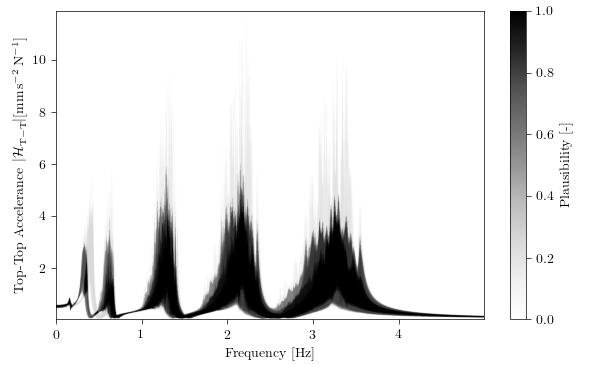

In [21]:
space_ind = 1
freq_ind = 1025-1

arr = np.load(os.path.join(result_dir,'estimations',f'frf-all.{space_ind}.npz'))
all_focals_this, focals_mass = arr['all_focals_this'][:freq_ind,:], arr['focals_mass']

all_focals_this *= 1000
# all_focals_this = np.log10(all_focals_this)
bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(all_focals_this,focals_mass,100)
n_bins_bel = bel_stats.shape[1]

cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
with matplotlib.rc_context(get_pcd('print')):
    plt.figure()
    im = plt.imshow(pl_stats.T, aspect='auto', extent= (0, 5/1025*freq_ind, np.min(all_focals_this), np.max(all_focals_this)),
                    cmap=cmap, origin='lower', vmin=0, vmax=1)
    
    cbar = plt.colorbar()
    cbar.set_label('Plausibility [-]')
    
    plt.xlabel('Frequency [\\si{\\hertz}]')    
    if space_ind==2:
        plt.ylabel('Top-TMD Accelerance $|\mathcal{H}_\mathrm{T-D}| [\\si{\\milli\\metre\\per\\second\\squared\\per\\newton}]$')
    else:
        plt.ylabel('Top-Top Accelerance $|\mathcal{H}_\mathrm{T-T}| [\\si{\\milli\\metre\\per\\second\\squared\\per\\newton}]$')
    
    plt.subplots_adjust(top=0.97, bottom=0.125, left=0.095, right=1.0)
    
    plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-frf-all.{space_ind}.png')
    plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-frf-all.{space_ind}.pdf')
    plt.show()

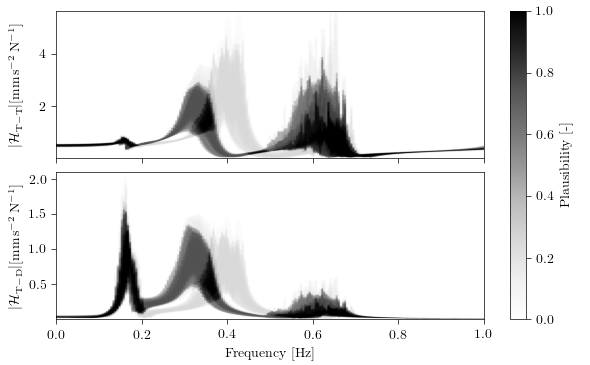

In [77]:
plt.close('all')
with matplotlib.rc_context(get_pcd('print')):
    fig, axes = plt.subplots(2,1,sharex=True, sharey=False)

    for space_ind in [1,2]:
        freq_ind = 206-1

        arr = np.load(os.path.join(result_dir,'estimations',f'frf-all.{space_ind}.npz'))
        all_focals_this, focals_mass = arr['all_focals_this'][:freq_ind,:], arr['focals_mass']

        all_focals_this *= 1000
        # omegas = np.arange(1,freq_ind+1)*5/1024*2*np.pi
        # all_focals_this /= omegas[:, np.newaxis, np.newaxis]**2
        # all_focals_this = np.log10(all_focals_this)
        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(all_focals_this,focals_mass,100)
        n_bins_bel = bel_stats.shape[1]

        cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
        im = axes[space_ind-1].imshow(pl_stats.T, aspect='auto', 
                                      extent= (0, 5/1025*freq_ind, np.min(all_focals_this), np.max(all_focals_this)),
                                      cmap=cmap, origin='lower', vmin=0, vmax=1)
        

        if space_ind==2:
            axes[space_ind-1].set_ylabel('$|\mathcal{H}_\mathrm{T-D}| [\\si{\\milli\\metre\\per\\second\\squared\\per\\newton}]$')
        else:
            axes[space_ind-1].set_ylabel('$|\mathcal{H}_\mathrm{T-T}| [\\si{\\milli\\metre\\per\\second\\squared\\per\\newton}]$')
    fig.align_ylabels()
    plt.subplots_adjust(top=0.97, bottom=0.125, left=0.095, right=1.0, hspace=0.1)
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_label('Plausibility [-]')

    axes[1].set_xlabel('Frequency [\\si{\\hertz}]')    


    plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-frf-low.all.png')
    plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/inc_avg_pl-frf-low.all.pdf')
    plt.show()